In [1]:
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy as np
import pandas as pd
import os
from copy import copy
from collections import OrderedDict
from scipy.stats import spearmanr
from tqdm import tqdm_notebook
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MODEL_PATH = '../models/dim_bow1000_5topics_alltracks_songreleasedate'
BOW_DIR = '../data/features/bow_1000/'

In [3]:
# Load model
dim_model = DtmModel.load(MODEL_PATH)

In [4]:
# Load artist info
artists = pd.read_csv('../data/allmusic/artists_cleaned.csv')

In [5]:
# Load song info
songs = pd.read_csv('../data/artist_song_list_years_cleaned.csv')

In [6]:
# Load bow_path_by_artist
bow_path_by_artist = pickle.load(open('../models/dim_bow1000_5topics_alltracks_songreleasedatebow_paths.pk', 'rb'))

In [7]:
bow_path_by_artist_new = []

for (id, path, year) in bow_path_by_artist:
    bow_path_by_artist_new.append((id, BOW_DIR + path, year))

bow_path_by_artist = bow_path_by_artist_new

In [8]:
# Order list by year
bow_path_by_artist.sort(key= lambda x: songs[songs['artist_id'] == x[0]]['year'].iloc[0])

# Create counter for number of songs for each year 
year_counter = {int(k) : 0 for k in np.unique(zip(*bow_path_by_artist)[2])}

for id, path, year in bow_path_by_artist:
    year_counter[year] += 1

# Lookup table for time_slice index v. year
time_slice_dict = {idx : year for (idx, year) in enumerate(sorted(year_counter))}
# List of counts for each time slice for DIM
time_seq = [year_counter[key] for key in sorted(year_counter.keys())]

print "Count of songs per each time slice:"
print time_seq

Count of songs per each time slice:
[1, 1, 1, 2, 1, 3, 1, 3, 3, 12, 13, 6, 7, 21, 28, 23, 19, 9, 5, 10, 2, 11, 17, 13, 16, 15, 16, 25, 38, 13, 36, 54, 55, 47, 41, 51, 61, 67, 65, 114, 153, 297, 421, 405, 476, 475, 411, 453, 474, 560, 554, 717, 801, 878, 954, 995, 1038, 1001, 1136, 1207, 1066, 1196, 1288, 1251, 1367, 1435, 1573, 1483, 1500, 1560, 1372, 1576, 1582, 1524, 1679, 1706, 1839, 1941, 2201, 2530, 2616, 2977, 3341, 3404, 3832, 3641, 3820, 3935, 3723, 4236, 4058, 3828, 4035, 3903, 3637, 2903, 2992, 2751, 2719, 3122, 3586, 2583, 2588, 1722, 12]


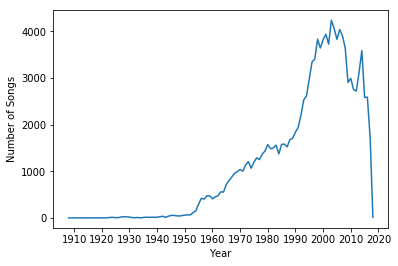

In [16]:
# Plot count of songs per each time slice
plt.locator_params(nbins=20,axis='x') 
plt.plot(time_slice_dict.values(), time_seq)
plt.xlabel('Year')
plt.ylabel('Number of Songs')

# Get most influential songs for each topic

In [9]:
# Create (num_songs, num_topics) array of influence scores
song_topic_inf_matrix = []

for time_idx in range(len(dim_model.time_slices)):    
    for song_idx in range(dim_model.time_slices[time_idx]):
        song_inf_by_topic = [None] * dim_model.num_topics

        for topic_idx in range(dim_model.num_topics):
            song_inf_by_topic[topic_idx] = dim_model.influences_time[time_idx][song_idx][topic_idx]
        
        song_topic_inf_matrix.append(song_inf_by_topic)

In [11]:
# Get the indices of the most influential songs per topic
most_inf_idx = np.array(song_topic_inf_matrix).argmax(axis=0)

for topic_no, artist_idx in enumerate(most_inf_idx):
    print "Topic:", topic_no
    # Lookup artist name
    print artists[artists['id'] == bow_path_by_artist[artist_idx][0]]['name'].iloc[0]
    # Lookup name of sample
    print os.listdir(bow_path_by_artist[artist_idx][1])[0]
    
    print

Topic: 0
Liaisons Dangereuses


OSError: [Errno 20] Not a directory: '../data/features/bow_1000/0000225039/9_Etre Assis Ou Danser.npy'

# Get most influential songs per topic per epoch

In [9]:
song_topic_inf_by_year = []
song_topic_inf_matrix_copy = copy(song_topic_inf_matrix)

# Slice song-topic matrix into list of submatrices keyed by time slice
for time_idx, num_in_slice in enumerate(dim_model.time_slices):
    song_topic_inf_by_year.append(song_topic_inf_matrix_copy[:num_in_slice])
    del song_topic_inf_matrix_copy[:num_in_slice]

NameError: name 'song_topic_inf_matrix' is not defined

In [ ]:
for idx, song_topic_matrix in enumerate(song_topic_inf_by_year):
    print time_slice_dict[idx], ':', time_seq[idx], 'songs'
    print "==============================="

    # Get the indices of the most influential songs per topic
    # Note: Need to adjust indexing since index resets to 0 for each new year
    most_inf_idx = np.array(song_topic_matrix).argmax(axis=0) + sum(dim_model.time_slices[:idx])

    for topic_no, artist_idx in enumerate(most_inf_idx):
        print "Topic:", topic_no
        # Lookup artist name
        print artists[artists['id'] == bow_path_by_artist[artist_idx][0]]['name'].iloc[0]
        # Lookup name of sample
        print os.listdir(bow_path_by_artist[artist_idx][1])[0]
        print artists[artists['id'] == bow_path_by_artist[artist_idx][0]]['main_genre'].iloc[0]
        print

# Correlation with AllMusic Influence Graph Degree

In [10]:
# Calculate max DIM influence per artist
max_dim_influences = np.array(song_topic_inf_matrix).max(axis=1)

# Get list of artist outdegrees in same order
artist_ids_ordered = [t[0] for t in bow_path_by_artist]
outdegrees_ordered = []

for id in artist_ids_ordered:
    outdegrees_ordered.append(artists[artists['id'] == id]['outdegree'].iloc[0])

In [11]:
# Create df
artist_influences_df = pd.DataFrame({'id':artist_ids_ordered, 'outdegree':outdegrees_ordered, 'influence':max_dim_influences})
# Group by artist_id and take mean to get mean influence per artist
mean_inf_df = artist_influences_df.groupby(by='id').mean()
# Calculate correlation
spearmanr(mean_inf_df['influence'].values, mean_inf_df['outdegree'].values)

SpearmanrResult(correlation=0.17372803357979283, pvalue=2.2535122794427477e-99)

# TODO: Baseline

# TODO: Breakdown by Genre